In [0]:
#这个文件是用strength来预测distribute的  用flipped 和 nonflipped数据来跑模型
# !pip install import-ipynb
# import import_ipynb

%tensorflow_version 1.x

TensorFlow 1.x selected.


In [1]:

import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 
from keras.models import Model, Sequential 
from keras.layers import Conv1D,Flatten,Conv2D, Dropout, MaxPooling2D, Input,Conv3D, MaxPooling3D, Dense, BatchNormalization
from keras.layers.merge import concatenate 
from keras.layers import Flatten 
from google.colab import drive
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
drive.mount('/content/drive')
# %cp -av fromfolder tofolder
# %cd "/content/drive/My Drive/Newdata/"
# from model_functions import *

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# nonflipped全保留数据 转化成 strength

In [0]:
#将 24 个 150,30,116 穿连到一起 变成3600,30,116   数据较小  不需要保存
# num = np.load('/content/drive/My Drive/strength/nonflipped/all/1.npy')
# num = np.reshape(num,(150,30,116))
# for i in range(2,25):
#   Num = np.load('/content/drive/My Drive/strength/nonflipped/all/' + str(i) + '.npy')
#   Num = np.reshape(Num,(150,30,116)) 
#   num = np.concatenate((num,Num),axis = 0)

# print(num.shape)   #(3600, 30, 116)

(3600, 30, 116)


In [0]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/strength/nonflipped/all/' + str(tmp)+ '.npy')
A = np.reshape(A,(150,30,116))
for i in order[1:18]: 
  a = np.load('/content/drive/My Drive/strength/nonflipped/all/' + str(i)+ '.npy')
  a = np.reshape(a,(150,30,116))
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(2700, 30, 116)


tmp = order[0]
B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(tmp)+ '.npy')
for i in order[1:18]: 
  b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(i)+ '.npy')
  B = np.concatenate((B,b), axis = 0)
print(B.shape)
# 前十八个 病人数据做训练label(2700, 3)

tmp = order[18]
C = np.load('/content/drive/My Drive/strength/nonflipped/all/' + str(tmp)+ '.npy')
C = np.reshape(C,(150,30,116))
for i in order[19:]: 
  c = np.load('/content/drive/My Drive/strength/nonflipped/all/' + str(i)+ '.npy')
  c = np.reshape(c,(150,30,116))
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(900, 30, 116)

tmp = order[18]
D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(tmp)+ '.npy')
for i in order[19:]: 
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(i)+ '.npy')
  D = np.concatenate((D,d), axis = 0)
print(D.shape)
# 后六个人 病人数据做测试label(900, 3)

# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original', A)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original', C)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

range(1, 25)
[6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]
(2700, 30, 116)
(2700, 3)
(900, 30, 116)
(900, 3)


In [0]:
train_data = A
train_label = B
test_data = C
test_label = D

train_data = np.reshape(train_data,(2700,30,116,1))
test_data = np.reshape(test_data,(900,30,116,1)) 

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(2700, 30, 116, 1)
(2700, 3)
(900, 30, 116, 1)
(900, 3)


In [0]:
def Model():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform', input_shape=(30, 116, 1)))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(64, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(128, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(256, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(128, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(64, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Flatten())
  # model.add(Dense(3200, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(3, activation='softmax'))
  model.add(Dense(3))
  model.summary()
  from keras.optimizers import RMSprop,Adam
  model.compile(optimizer = Adam(lr=0.0001),
                loss = 'mean_squared_error',
                metrics = ['mae'])
  return model



In [0]:
num_epochs = 100
batchsize = 6
model = Model()
history = model.fit(train_data, train_label, epochs=num_epochs, batch_size=batchsize, verbose=1)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 29, 113, 32)       288       
_________________________________________________________________
batch_normalization_49 (Batc (None, 29, 113, 32)       128       
_________________________________________________________________
dropout_49 (Dropout)         (None, 29, 113, 32)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 110, 64)       16448     
_________________________________________________________________
batch_normalization_50 (Batc (None, 28, 110, 64)       256       
_________________________________________________________________
dropout_50 (Dropout)         (None, 28, 110, 64)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 27, 107, 128)    

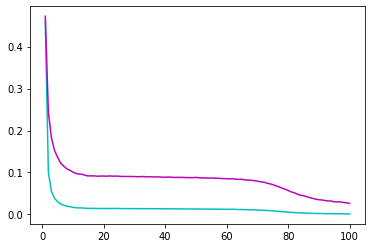

In [0]:
mse_history = history.history['loss']
mae_history = history.history['mae']

epochs = range(1,len(mse_history) +1)
plt.plot(epochs, mse_history, 'c', label='mse')
plt.plot(epochs, mae_history, 'm', label='mae')

# plt.savefig('/content/drive/My Drive/original4800_50epo_mse_mae1.png' ,dpi=1200)

array([-0.19535316, -0.75041473, -0.5945161 ])

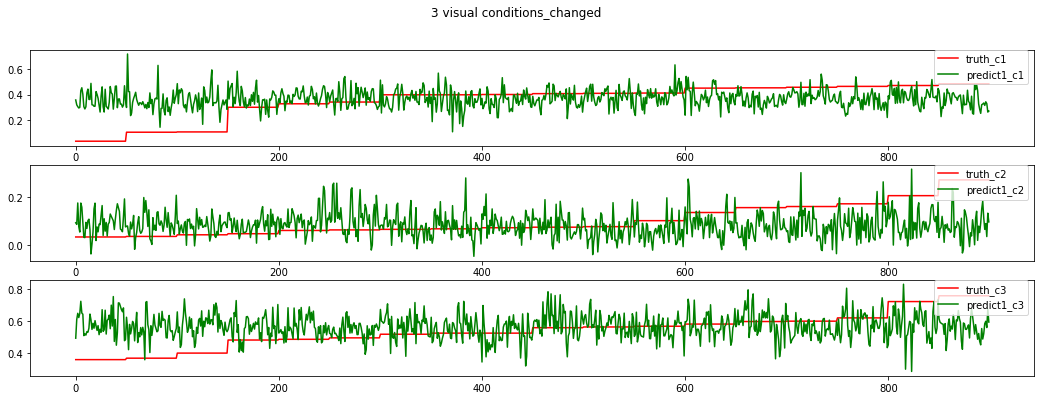

In [0]:

# comparision1 = (model.predict(test_data))*100
# Test_label = test_label*100
comparision1 = (model.predict(test_data))
Test_label = test_label
# comparision1 , Test_label = shuffle(comparision1, Test_label)
x_data = range(900)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(18,6))
fig.suptitle('3 visual conditions_changed') 

predict_c1.plot(x_data, y_data_c1[np.argsort(y_data_c1)] , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2[np.argsort(y_data_c2)] , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3[np.argsort(y_data_c3)] , 'r', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1[np.argsort(y_data_c1)] , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2[np.argsort(y_data_c2)] , 'g', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3[np.argsort(y_data_c3)] , 'g', label='predict1_c3')
predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)

# plt.savefig('/content/drive/My Drive/original4800_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')

# nonflipped保留最强30%数据 转化成 strength

In [2]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/strength/nonflipped/keep_30/' + str(tmp)+ '.npy')
A = np.reshape(A,(150,30,116))
for i in order[1:18]: 
  a = np.load('/content/drive/My Drive/strength/nonflipped/keep_30/' + str(i)+ '.npy')
  a = np.reshape(a,(150,30,116))
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(2700, 30, 116)


tmp = order[0]
B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(tmp)+ '.npy')
for i in order[1:18]: 
  b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(i)+ '.npy')
  B = np.concatenate((B,b), axis = 0)
print(B.shape)
# 前十八个 病人数据做训练label(2700, 3)

tmp = order[18]
C = np.load('/content/drive/My Drive/strength/nonflipped/keep_30/' + str(tmp)+ '.npy')
C = np.reshape(C,(150,30,116))
for i in order[19:]: 
  c = np.load('/content/drive/My Drive/strength/nonflipped/keep_30/' + str(i)+ '.npy')
  c = np.reshape(c,(150,30,116))
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(900, 30, 116)

tmp = order[18]
D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(tmp)+ '.npy')
for i in order[19:]: 
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(i)+ '.npy')
  D = np.concatenate((D,d), axis = 0)
print(D.shape)
# 后六个人 病人数据做测试label(900, 3)

# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original', A)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original', C)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

range(1, 25)
[6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]
(2700, 30, 116)
(2700, 3)
(900, 30, 116)
(900, 3)


In [3]:
train_data = A
train_label = B
test_data = C
test_label = D

train_data = np.reshape(train_data,(2700,30,116,1))
test_data = np.reshape(test_data,(900,30,116,1)) 

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(2700, 30, 116, 1)
(2700, 3)
(900, 30, 116, 1)
(900, 3)


In [0]:
def Model():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform', input_shape=(30, 116, 1)))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(64, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(128, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(256, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(128, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(64, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Flatten())
  # model.add(Dense(3200, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(3, activation='softmax'))
  model.add(Dense(3))
  model.summary()
  from keras.optimizers import RMSprop,Adam
  model.compile(optimizer = Adam(lr=0.0001),
                loss = 'mean_squared_error',
                metrics = ['mae'])
  return model



In [5]:
num_epochs = 50
batchsize = 6
model = Model()
history = model.fit(train_data, train_label, epochs=num_epochs, batch_size=batchsize, verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 29, 113, 32)       288       
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 113, 32)       128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 113, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 110, 64)       16448     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 110, 64)       256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 110, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 107, 128)     

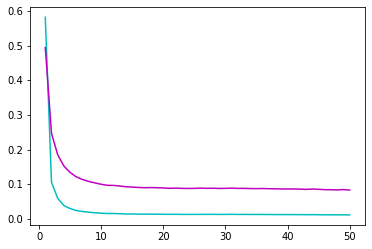

In [6]:
mse_history = history.history['loss']
mae_history = history.history['mae']

epochs = range(1,len(mse_history) +1)
plt.plot(epochs, mse_history, 'c', label='mse')
plt.plot(epochs, mae_history, 'm', label='mae')

# plt.savefig('/content/drive/My Drive/original4800_50epo_mse_mae1.png' ,dpi=1200)

array([-0.12027757, -0.23087522, -3.18537201])

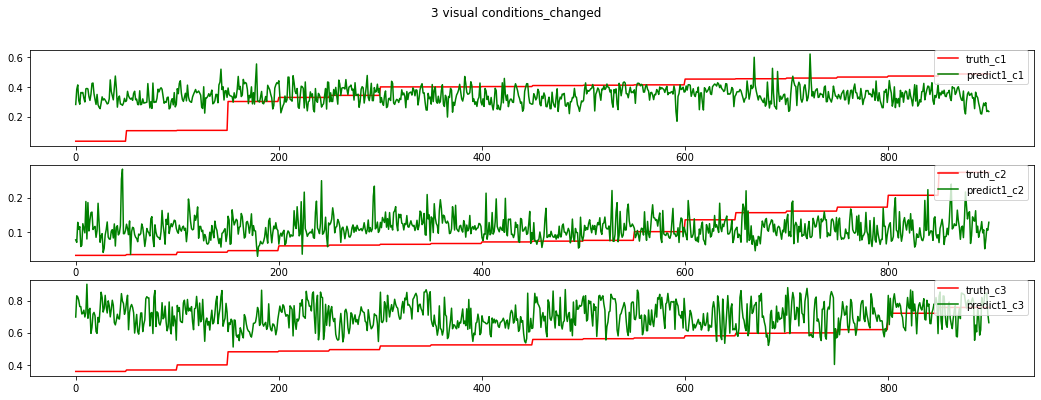

In [7]:

# comparision1 = (model.predict(test_data))*100
# Test_label = test_label*100
comparision1 = (model.predict(test_data))
Test_label = test_label
# comparision1 , Test_label = shuffle(comparision1, Test_label)
x_data = range(900)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(18,6))
fig.suptitle('3 visual conditions_changed') 

predict_c1.plot(x_data, y_data_c1[np.argsort(y_data_c1)] , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2[np.argsort(y_data_c2)] , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3[np.argsort(y_data_c3)] , 'r', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1[np.argsort(y_data_c1)] , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2[np.argsort(y_data_c2)] , 'g', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3[np.argsort(y_data_c3)] , 'g', label='predict1_c3')
predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)

# plt.savefig('/content/drive/My Drive/original4800_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')

# flipped全保留数据 转化成 strength

In [0]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/strength/flipped/all/' + str(tmp)+ '.npy')
A = np.reshape(A,(150,30,116))
for i in order[1:18]: 
  a = np.load('/content/drive/My Drive/strength/flipped/all/' + str(i)+ '.npy')
  a = np.reshape(a,(150,30,116))
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(2700, 30, 116)


tmp = order[0]
B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(tmp)+ '.npy')
for i in order[1:18]: 
  b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(i)+ '.npy')
  B = np.concatenate((B,b), axis = 0)
print(B.shape)
# 前十八个 病人数据做训练label(2700, 3)

tmp = order[18]
C = np.load('/content/drive/My Drive/strength/flipped/all/' + str(tmp)+ '.npy')
C = np.reshape(C,(150,30,116))
for i in order[19:]: 
  c = np.load('/content/drive/My Drive/strength/flipped/all/' + str(i)+ '.npy')
  c = np.reshape(c,(150,30,116))
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(900, 30, 116)

tmp = order[18]
D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(tmp)+ '.npy')
for i in order[19:]: 
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(i)+ '.npy')
  D = np.concatenate((D,d), axis = 0)
print(D.shape)
# 后六个人 病人数据做测试label(900, 3)

# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original', A)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original', C)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

In [0]:
train_data = A
train_label = B
test_data = C
test_label = D

train_data = np.reshape(train_data,(2700,30,116,1))
test_data = np.reshape(test_data,(900,30,116,1)) 

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

In [0]:
def Model():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform', input_shape=(30, 116, 1)))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(64, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(128, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(256, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(128, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(64, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2, 4), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Flatten())
  # model.add(Dense(3200, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(3, activation='softmax'))
  model.add(Dense(3))
  model.summary()
  from keras.optimizers import RMSprop,Adam
  model.compile(optimizer = Adam(lr=0.0001),
                loss = 'mean_squared_error',
                metrics = ['mae'])
  return model



In [0]:
num_epochs = 100
batchsize = 6
model = Model()
history = model.fit(train_data, train_label, epochs=num_epochs, batch_size=batchsize, verbose=1)


In [0]:
mse_history = history.history['loss']
mae_history = history.history['mae']

epochs = range(1,len(mse_history) +1)
plt.plot(epochs, mse_history, 'c', label='mse')
plt.plot(epochs, mae_history, 'm', label='mae')

# plt.savefig('/content/drive/My Drive/original4800_50epo_mse_mae1.png' ,dpi=1200)

In [0]:

# comparision1 = (model.predict(test_data))*100
# Test_label = test_label*100
comparision1 = (model.predict(test_data))
Test_label = test_label
# comparision1 , Test_label = shuffle(comparision1, Test_label)
x_data = range(900)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(18,6))
fig.suptitle('3 visual conditions_changed') 

predict_c1.plot(x_data, y_data_c1[np.argsort(y_data_c1)] , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2[np.argsort(y_data_c2)] , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3[np.argsort(y_data_c3)] , 'r', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1[np.argsort(y_data_c1)] , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2[np.argsort(y_data_c2)] , 'g', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3[np.argsort(y_data_c3)] , 'g', label='predict1_c3')
predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)

# plt.savefig('/content/drive/My Drive/original4800_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')

# flipped保留最强30%数据 转化成 strength

# 把30赫兹频率变成6个 

In [0]:
def from_30_to_6(Num):
  data = Num[:]
  New_6 = []
  for i in range(150):

  # i = 0
    delta = (data[i,0] + data[i,1] + data[i,2])/3 
    delta = np.reshape(delta, (1,116,116))
    theta = (data[i,3] + data[i,4] + data[i,5] + data[i,6])/4 
    theta = np.reshape(theta, (1,116,116))
    alpha_low = (data[i,7] + data[i,8] + data[i,9])/3  
    alpha_low = np.reshape(alpha_low, (1,116,116))
    alpha_high = (data[i,10] + data[i,11] + data[i,12])/3  
    alpha_high = np.reshape(alpha_high, (1,116,116))
    beta_1 = (data[i,13] + data[i,14] + data[i,15] + data[i,16] + data[i,17] + data[i,18] + data[i,19] + data[i,20])/8 
    beta_1 = np.reshape(beta_1, (1,116,116))
    beta_2 = (data[i,21] + data[i,22] + data[i,23] + data[i,24] + data[i,25] + data[i,26] + data[i,27] + data[i,28] + data[i,29])/9 
    beta_2 = np.reshape(beta_2, (1,116,116))
    new_6 = np.concatenate((delta,theta,alpha_low,alpha_high,beta_1,beta_2), axis = 0) 
    New_6.append(new_6)
    new_6 = 0

  New_6  = np.array(New_6)
  return New_6

In [0]:
for i in range(1,25):
  Num = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/115_30_116_116_' + str(i) + '.npy')
  tmp = from_30_to_6(Num)
  np.save('/content/drive/My Drive/Newdata/ordered_by_patient/150_6_116_116_' + str(i)+ '.npy', tmp)
#这里保存的是没有flipped的数据  按24个病人来分的

In [0]:
aaa = np.load('/content/drive/My Drive/Newdata/changed/allpre.npy')
bbb = np.load('/content/drive/My Drive/Newdata/changed/allpost.npy')
ccc = np.load('/content/drive/My Drive/Newdata/changed/allfu.npy')

In [0]:
for i in range(24):
# i = 1

  Num = np.concatenate((aaa[i*50:(i+1)*50],bbb[i*50:(i+1)*50],ccc[i*50:(i+1)*50]), axis = 0)
  tmp = from_30_to_6(Num)
  np.save('/content/drive/My Drive/Newdata/ordered_by_patient/150_6_116_116_' + str(i+1)+ '_flipped.npy', tmp)
# 这里保存的是 flipped后的数据   按24个病人来分的
  # print(i)

# 载入非flipped数据


In [0]:
train_data = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original.npy')
train_label = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3.npy')
test_data =  np.load('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original.npy')
test_label = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3.npy')

# train_data = A
# train_label = B
# test_data = C
# test_label = D

train_data = np.reshape(train_data,(2700,6,116,116,1))
test_data = np.reshape(test_data,(900,6,116,116,1)) 

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(2700, 6, 116, 116, 1)
(2700, 3)
(900, 6, 116, 116, 1)
(900, 3)


# 载入flipped数据

In [0]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/150_6_116_116_' + str(tmp)+ '_flipped.npy')
for i in order[1:18]: 
  a = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/150_6_116_116_' + str(i)+ '_flipped.npy')
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(2700, 30, 116, 116)


# tmp = order[0]
# B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(tmp)+ '.npy')
# for i in order[1:18]: 
#   b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(i)+ '.npy')
#   B = np.concatenate((B,b), axis = 0)
# print(B.shape)
# # 前十八个 病人数据做训练label(2700, 21, 21)

tmp = order[18]
C = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/150_6_116_116_' + str(tmp)+ '_flipped.npy')
for i in order[19:]: 
  c = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/150_6_116_116_' + str(i)+ '_flipped.npy')
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(900, 30, 116, 116)

# tmp = order[18]
# D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(tmp)+ '.npy')
# for i in order[19:]: 
#   d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(i)+ '.npy')
#   D = np.concatenate((D,d), axis = 0)
# print(D.shape)
# # 后六个人 病人数据做测试label(900, 21, 21)

np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_flipped', A)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_flipped', C)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

range(1, 25)
[6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]
(2700, 6, 116, 116)
(900, 6, 116, 116)


In [0]:
# train_data = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_flipped.npy')
train_label = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3.npy')
# test_data =  np.load('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_flipped.npy')
test_label = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3.npy')

train_data = A
# train_label = B
test_data = C
# test_label = D

train_data = np.reshape(train_data,(2700,6,116,116,1))
test_data = np.reshape(test_data,(900,6,116,116,1)) 

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(2700, 6, 116, 116, 1)
(2700, 3)
(900, 6, 116, 116, 1)
(900, 3)


# 模型部分

In [0]:
def Model():
  model = Sequential()
  model.add(Conv3D(128, kernel_size=(1, 6, 6), activation='relu', kernel_initializer='he_uniform', input_shape=(6,116,116, 1)))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv3D(64, kernel_size=(1, 6, 6), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  model.add(BatchNormalization()) 
  model.add(Dropout(0.5))
  model.add(Conv3D(32, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  # model.add(Conv3D(30, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(40, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(50, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(60, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(70, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(80, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(90, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(100, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(90, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(80, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(70, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(60, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(50, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(40, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(30, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(20, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(10, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # # model.add(Dropout(0.5))
  # model.add(Conv3D(1, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # # model.add(MaxPooling3D(pool_size=(1, 1, 1)))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.5))
  model.add(Flatten())
  # model.add(Dense(3200, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1028, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(3, activation='softmax'))
  model.add(Dense(3))
  model.summary()
  from keras.optimizers import RMSprop,Adam
  model.compile(optimizer = Adam(lr=0.0001),
                loss = 'mean_squared_error',
                metrics = ['mae'])
  return model



In [0]:

# data = np.load('/content/drive/My Drive/Newdata/shuffle_originalin3600.npy')
# label =  np.load('/content/drive/My Drive/Newdata/shuffle_originalout3600.npy')
# k = 5
# num_val_samples = len(data)//k
# # for i in range(k):
# i = 2
# print('processing fold #', i)
# test_data = data[i * num_val_samples: (i + 1) * num_val_samples]
# test_label = label[i * num_val_samples: (i + 1) * num_val_samples]
# train_data = np.concatenate([data[:i * num_val_samples],data[(i + 1) * num_val_samples:]], axis=0)
# train_label = np.concatenate([label[:i * num_val_samples],label[(i + 1) * num_val_samples:]], axis=0)
# np.save('/content/drive/My Drive/Newdata/'+str(i)+'_fold_trainin_original3600', train_data)
# # np.save('/content/drive/My Drive/Newdata/'+str(i)+'_fold_trainout_original3600', train_label)
# # np.save('/content/drive/My Drive/Newdata/'+str(i)+'_fold_testin_original3600', test_data)
# # np.save('/content/drive/My Drive/Newdata/'+str(i)+'_fold_testout_original3600', test_label)



# 跑模型

In [0]:
num_epochs = 50
batchsize = 12
model = Model()
history = model.fit(train_data, train_label, epochs=num_epochs, batch_size=batchsize, verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 6, 111, 111, 128)  4736      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 55, 55, 128)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 55, 55, 128)    512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 55, 55, 128)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 6, 50, 50, 64)     294976    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 6, 25, 25, 64)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 25, 25, 64)    

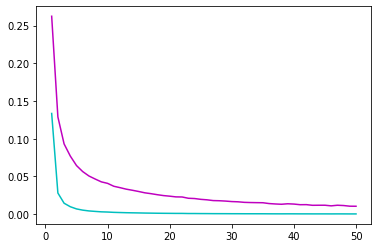

In [0]:
mse_history = history.history['loss']
mae_history = history.history['mae']

epochs = range(1,len(mse_history) +1)
plt.plot(epochs, mse_history, 'c', label='mse')
plt.plot(epochs, mae_history, 'm', label='mae')

# plt.savefig('/content/drive/My Drive/original4800_50epo_mse_mae1.png' ,dpi=1200)

array([-1.63628163, -0.43724307, -1.03029477])

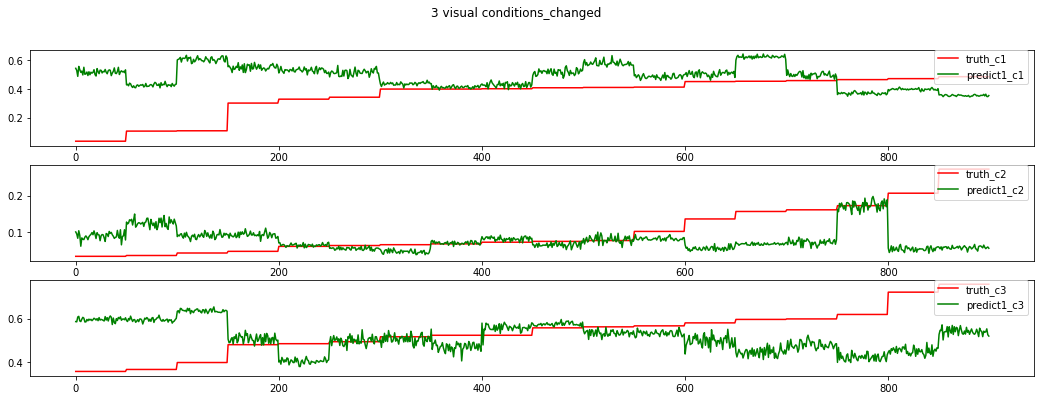

In [0]:

# comparision1 = (model.predict(test_data))*100
# Test_label = test_label*100
comparision1 = (model.predict(test_data))
Test_label = test_label
# comparision1 , Test_label = shuffle(comparision1, Test_label)
x_data = range(900)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(18,6))
fig.suptitle('3 visual conditions_changed') 

predict_c1.plot(x_data, y_data_c1[np.argsort(y_data_c1)] , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2[np.argsort(y_data_c2)] , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3[np.argsort(y_data_c3)] , 'r', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1[np.argsort(y_data_c1)] , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2[np.argsort(y_data_c2)] , 'g', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3[np.argsort(y_data_c3)] , 'g', label='predict1_c3')
predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)

# plt.savefig('/content/drive/My Drive/original4800_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')